## CSIRO Image2Biomass – Dual Ensemble Inference

In [1]:
import torch
print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")
print(f"GPU memory reserved: {torch.cuda.memory_reserved()/1e9:.2f} GB")

GPU memory allocated: 0.00 GB
GPU memory reserved: 0.00 GB


/usr/local/lib/python3.11/dist-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context

Device: cuda

================= Loading test data =================
Found 1 unique test images.

================= Ensemble A inference =================

================= Loading models (5 folds) =================
fold1 => variant=tiled_film, backbone=vit_base_patch14_reg4_dinov2, input_res=518
tiled_film_best_model_fold2.pth => variant=tiled_film, backbone=vit_base_patch14_reg4_dinov2, input_res=518
tiled_film_best_model_fold3.pth => variant=tiled_film, backbone=vit_base_patch14_reg4_dinov2, input_res=518
tiled_film_best_model_fold4.pth => variant=tiled_film, backbone=vit_base_patch14_reg4_dinov2, input_res=518
tiled_film_best_model_fold5.pth => variant=tiled_film, backbone=vit_base_patch14_reg4_dinov2, input_res=518

--- TTA view 1/3 (resize=518) ---



--- TTA view 2/3 (resize=518) ---



--- TTA view 3/3 (resize=518) ---



================= Ensemble B inference =================

================= Loading models (5 folds) =================
fold1 => variant=tiled_film, backbone=vit_base_patch14_reg4_dinov2, input_res=518
tiled_film_best_model_fold2.pth => variant=tiled_film, backbone=vit_base_patch14_reg4_dinov2, input_res=518
tiled_film_best_model_fold3.pth => variant=tiled_film, backbone=vit_base_patch14_reg4_dinov2, input_res=518
tiled_film_best_model_fold4.pth => variant=tiled_film, backbone=vit_base_patch14_reg4_dinov2, input_res=518
tiled_film_best_model_fold5.pth => variant=tiled_film, backbone=vit_base_patch14_reg4_dinov2, input_res=518

--- TTA view 1/3 (resize=518) ---



--- TTA view 2/3 (resize=518) ---



--- TTA view 3/3 (resize=518) ---



🎉 Generated submission file: submission.csv
                    sample_id     target
0  ID1001187975__Dry_Clover_g   1.793295
1    ID1001187975__Dry_Dead_g  26.128004
2   ID1001187975__Dry_Green_g  32.120895
3   ID1001187975__Dry_Total_g  60.042198
4         ID1001187975__GDM_g  33.914192

================= Generating Visualizations =================


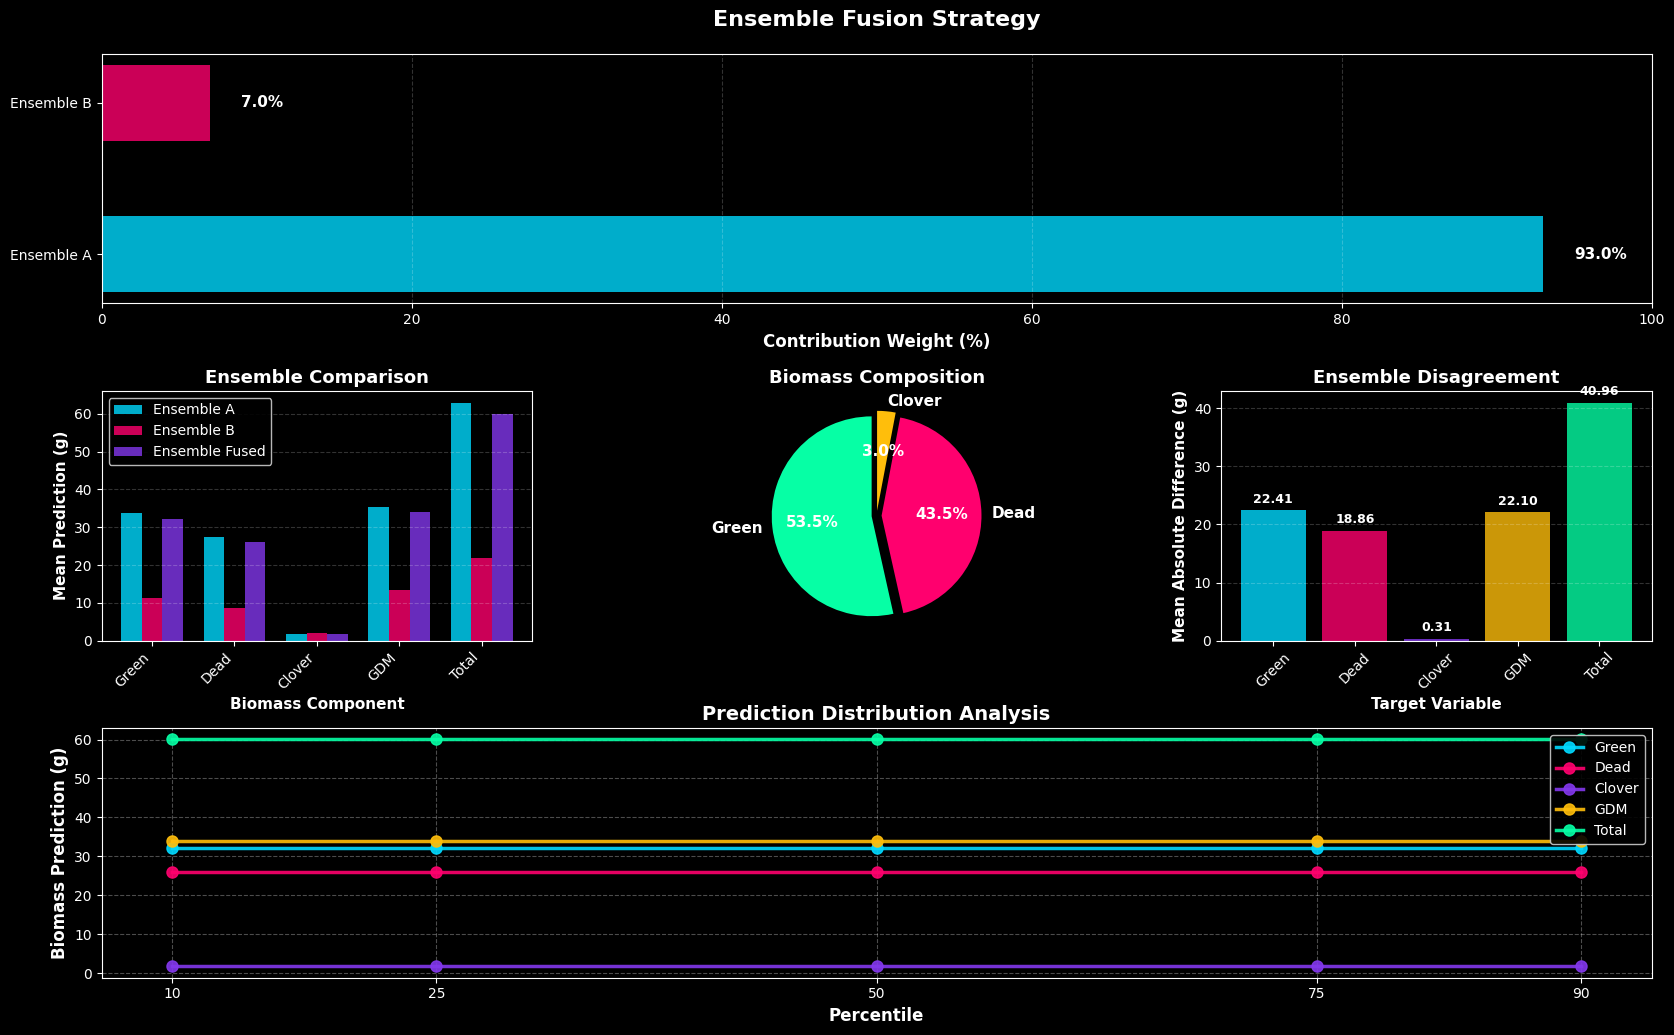


📊 Visualization saved: ensemble_analysis.png


In [1]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

class CFG:
    BASE_PATH = "/kaggle/input/csiro-biomass"
    TEST_CSV = os.path.join(BASE_PATH, "test.csv")
    TEST_IMAGE_DIR = os.path.join(BASE_PATH, "test")

    MODEL_DIR_A = "/kaggle/input/m/gothamjocker/csiro/pytorch/default/6"
    CKPTS_A = [
        os.path.join(MODEL_DIR_A, "tiled_film_best_model_fold1.pth"),
        os.path.join(MODEL_DIR_A, "tiled_film_best_model_fold2.pth"),
        os.path.join(MODEL_DIR_A, "tiled_film_best_model_fold3.pth"),
        os.path.join(MODEL_DIR_A, "tiled_film_best_model_fold4.pth"),
        os.path.join(MODEL_DIR_A, "tiled_film_best_model_fold5.pth"),
    ]

    MODEL_DIR_B = "/kaggle/input/m/gothamjocker/csiro/pytorch/default/11"
    CKPTS_B = [
        os.path.join(MODEL_DIR_B, "tiled_film_best_model_fold1.pth"),
        os.path.join(MODEL_DIR_B, "tiled_film_best_model_fold2.pth"),
        os.path.join(MODEL_DIR_B, "tiled_film_best_model_fold3.pth"),
        os.path.join(MODEL_DIR_B, "tiled_film_best_model_fold4.pth"),
        os.path.join(MODEL_DIR_B, "tiled_film_best_model_fold5.pth"),
    ]

    W_A = 0.93
    W_B = 0.07

    SUBMISSION_FILE = "submission.csv"
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 1
    NUM_WORKERS = 0

    DROPOUT = 0.30
    HIDDEN_RATIO = 0.25
    GRID = (2, 2)

    ALL_TARGET_COLS = ["Dry_Green_g", "Dry_Dead_g", "Dry_Clover_g", "GDM_g", "Dry_Total_g"]

    DINO_CANDIDATES = [
        "vit_base_patch14_dinov3",
        "vit_base_patch14_reg4_dinov3",
        "vit_small_patch14_dinov3",
        "vit_base_patch14_reg4_dinov2",
        "vit_base_patch14_dinov2",
        "vit_small_patch14_dinov2",
    ]

print(f"Device: {CFG.DEVICE}")

class TestBiomassDataset(Dataset):
    def __init__(self, df, transform, image_dir):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.image_dir = image_dir
        self.paths = self.df["image_path"].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = os.path.basename(self.paths[idx])
        full_path = os.path.join(self.image_dir, filename)
        img = cv2.imread(full_path)
        if img is None:
            img = np.zeros((1000, 2000, 3), dtype=np.uint8)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        h, w, _ = img.shape
        mid = w // 2
        left = img[:, :mid]
        right = img[:, mid:]

        left_t = self.transform(image=left)["image"]
        right_t = self.transform(image=right)["image"]
        return left_t, right_t

def _infer_input_res(m) -> int:
    if hasattr(m, "patch_embed") and hasattr(m.patch_embed, "img_size"):
        isz = m.patch_embed.img_size
        return int(isz if isinstance(isz, (int, float)) else isz[0])
    if hasattr(m, "img_size"):
        isz = m.img_size
        return int(isz if isinstance(isz, (int, float)) else isz[0])
    dc = getattr(m, "default_cfg", {}) or {}
    ins = dc.get("input_size", None)
    if ins:
        if isinstance(ins, (tuple, list)) and len(ins) >= 2:
            return int(ins[1])
        return int(ins if isinstance(ins, (int, float)) else 224)
    name = getattr(m, "default_cfg", {}).get("architecture", "") or str(type(m))
    return 518 if ("dinov2" in name.lower()) else 224

def _build_dino_by_name(name: str):
    m = timm.create_model(name, pretrained=False, num_classes=0)
    feat = m.num_features
    input_res = _infer_input_res(m)
    return m, feat, input_res

class TwoStreamDINOBase(nn.Module):
    def __init__(self, backbone_name: str, dropout: float = 0.3, hidden_ratio: float = 0.25):
        super().__init__()
        self.backbone, feat, input_res = _build_dino_by_name(backbone_name)
        self.used_backbone_name = backbone_name
        self.input_res = int(input_res)
        self.feat_dim = feat
        self.combined = feat * 2

        hidden = max(8, int(self.combined * hidden_ratio))

        def head():
            return nn.Sequential(
                nn.Linear(self.combined, hidden),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout),
                nn.Linear(hidden, 1),
            )

        self.head_green = head()
        self.head_clover = head()
        self.head_dead = head()
        self.softplus = nn.Softplus(beta=1.0)

    def _merge_heads(self, f_l: torch.Tensor, f_r: torch.Tensor):
        f = torch.cat([f_l, f_r], dim=1)
        green_pos = self.softplus(self.head_green(f))
        clover_pos = self.softplus(self.head_clover(f))
        dead_pos = self.softplus(self.head_dead(f))
        gdm = green_pos + clover_pos
        total = gdm + dead_pos
        return total, gdm, green_pos

class TwoStreamDINOPlain(TwoStreamDINOBase):
    def forward(self, x_left: torch.Tensor, x_right: torch.Tensor):
        f_l = self.backbone(x_left)
        f_r = self.backbone(x_right)
        return self._merge_heads(f_l, f_r)

def _make_edges(L: int, parts: int):
    step = L // parts
    edges = []
    start = 0
    for _ in range(parts - 1):
        edges.append((start, start + step))
        start += step
    edges.append((start, L))
    return edges

class TwoStreamDINOTiled(TwoStreamDINOBase):
    def __init__(self, backbone_name: str, grid=(2, 2), **kwargs):
        super().__init__(backbone_name, **kwargs)
        self.grid = tuple(grid)

    def _encode_tiles(self, x: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        r, c = self.grid
        rows = _make_edges(H, r)
        cols = _make_edges(W, c)
        feats = []
        for (rs, re) in rows:
            for (cs, ce) in cols:
                xt = x[:, :, rs:re, cs:ce]
                if xt.shape[-2:] != (self.input_res, self.input_res):
                    xt = F.interpolate(xt, size=(self.input_res, self.input_res), mode="bilinear", align_corners=False)
                ft = self.backbone(xt)
                feats.append(ft)
        feats = torch.stack(feats, dim=0).permute(1, 0, 2)
        feat_stream = feats.mean(dim=1)
        return feat_stream

    def forward(self, x_left: torch.Tensor, x_right: torch.Tensor):
        f_l = self._encode_tiles(x_left)
        f_r = self._encode_tiles(x_right)
        return self._merge_heads(f_l, f_r)

class FiLM(nn.Module):
    def __init__(self, in_dim: int):
        super().__init__()
        hid = max(32, in_dim // 2)
        self.mlp = nn.Sequential(nn.Linear(in_dim, hid), nn.ReLU(inplace=True), nn.Linear(hid, in_dim * 2))

    def forward(self, context: torch.Tensor):
        gb = self.mlp(context)
        gamma, beta = torch.chunk(gb, 2, dim=1)
        return gamma, beta

class TwoStreamDINOTiledFiLM(TwoStreamDINOBase):
    def __init__(self, backbone_name: str, grid=(2, 2), **kwargs):
        super().__init__(backbone_name, **kwargs)
        self.grid = tuple(grid)
        self.film_left = FiLM(self.feat_dim)
        self.film_right = FiLM(self.feat_dim)

    def _tiles_backbone(self, x: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        r, c = self.grid
        rows = _make_edges(H, r)
        cols = _make_edges(W, c)
        feats = []
        for (rs, re) in rows:
            for (cs, ce) in cols:
                xt = x[:, :, rs:re, cs:ce]
                if xt.shape[-2:] != (self.input_res, self.input_res):
                    xt = F.interpolate(xt, size=(self.input_res, self.input_res), mode="bilinear", align_corners=False)
                ft = self.backbone(xt)
                feats.append(ft)
        feats = torch.stack(feats, dim=0).permute(1, 0, 2)
        return feats

    def _encode_stream(self, x: torch.Tensor, film: FiLM) -> torch.Tensor:
        tiles = self._tiles_backbone(x)
        context = tiles.mean(dim=1)
        gamma, beta = film(context)
        tiles = tiles * (1 + gamma.unsqueeze(1)) + beta.unsqueeze(1)
        feat_stream = tiles.mean(dim=1)
        return feat_stream

    def forward(self, x_left: torch.Tensor, x_right: torch.Tensor):
        f_l = self._encode_stream(x_left, self.film_left)
        f_r = self._encode_stream(x_right, self.film_right)
        return self._merge_heads(f_l, f_r)

def _strip_module_prefix(sd: dict):
    if not sd:
        return sd
    keys = list(sd.keys())
    if all(k.startswith("module.") for k in keys):
        return {k[len("module.") :]: v for k, v in sd.items()}
    return sd

def _extract_student_substate(sd: dict) -> dict:
    sd = _strip_module_prefix(sd)
    has_student = any(k.startswith("student.") for k in sd.keys())
    if has_student:
        sd = {k[len("student.") :]: v for k, v in sd.items() if k.startswith("student.")}
    drop_prefixes = ("txt_enc.", "img_proj.", "txt_film_left.", "txt_film_right.")
    sd = {k: v for k, v in sd.items() if not k.startswith(drop_prefixes)}
    return sd

def _has_film(sd_keys: set) -> bool:
    return any(k.startswith("film_left.mlp.") for k in sd_keys) or any(k.startswith("film_right.mlp.") for k in sd_keys)

def _try_build_and_load(sd: dict, backbone_name: str, variant: str, grid=(2, 2)):
    if variant == "tiled_film":
        model = TwoStreamDINOTiledFiLM(backbone_name, grid=grid, dropout=CFG.DROPOUT, hidden_ratio=CFG.HIDDEN_RATIO)
    elif variant == "tiled":
        model = TwoStreamDINOTiled(backbone_name, grid=grid, dropout=CFG.DROPOUT, hidden_ratio=CFG.HIDDEN_RATIO)
    else:
        model = TwoStreamDINOPlain(backbone_name, dropout=CFG.DROPOUT, hidden_ratio=CFG.HIDDEN_RATIO)

    result = model.load_state_dict(sd, strict=False)
    missing = getattr(result, "missing_keys", [])
    unexpected = getattr(result, "unexpected_keys", [])
    if len(missing) == 0 and len(unexpected) == 0:
        model.to(CFG.DEVICE)
        model.eval()
        return model
    return None

def load_fold_model_auto(path: str, grid=(2, 2)):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    try:
        raw_sd = torch.load(path, map_location=CFG.DEVICE, weights_only=True)
    except TypeError:
        raw_sd = torch.load(path, map_location=CFG.DEVICE)
    sd = _extract_student_substate(raw_sd)
    keys = set(sd.keys())

    is_film = _has_film(keys)
    variant_order = ["tiled_film"] if is_film else ["tiled", "plain"]

    for variant in variant_order:
        for backbone in CFG.DINO_CANDIDATES:
            try:
                m = _try_build_and_load(sd, backbone, variant, grid=grid)
                if m is not None:
                    return m, variant, backbone
            except Exception:
                continue

    raise RuntimeError(
        f"Cannot find matching variant/backbone for {os.path.basename(path)}."
        f" Detected {'tiled_film' if is_film else 'non-film'} weights, please check training-inference consistency."
    )

def get_tta_transforms(img_size: int):
    base = [A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2()]
    original = A.Compose([A.Resize(img_size, img_size, interpolation=cv2.INTER_AREA), *base])
    hflip = A.Compose([A.HorizontalFlip(p=1.0), A.Resize(img_size, img_size, interpolation=cv2.INTER_AREA), *base])
    vflip = A.Compose([A.VerticalFlip(p=1.0), A.Resize(img_size, img_size, interpolation=cv2.INTER_AREA), *base])
    return [original, hflip, vflip]

@torch.no_grad()
def predict_one_view(models, loader):
    out_list = []
    amp_dtype = "cuda" if CFG.DEVICE.type == "cuda" else "cpu"

    for (xl, xr) in tqdm(loader, desc="  Predicting View", leave=False):
        xl = xl.to(CFG.DEVICE, non_blocking=True)
        xr = xr.to(CFG.DEVICE, non_blocking=True)

        per_model_preds = []
        with torch.amp.autocast(amp_dtype, enabled=(CFG.DEVICE.type == "cuda")):
            for m in models:
                total, gdm, green = m(xl, xr)
                dead = total - gdm
                clover = gdm - green
                five = torch.cat([green, dead, clover, gdm, total], dim=1)
                five = torch.clamp(five, min=0.0)
                per_model_preds.append(five.float().cpu())

        stacked = torch.mean(torch.stack(per_model_preds, dim=0), dim=0)
        out_list.append(stacked.numpy())

    return np.concatenate(out_list, axis=0)

def run_inference_for_ckpts(ckpt_list, test_unique, image_dir):
    print("\n================= Loading models (5 folds) =================")
    models = []

    m1, v1, b1 = load_fold_model_auto(ckpt_list[0], grid=CFG.GRID)
    models.append(m1)
    backbone_res = int(getattr(m1, "input_res", 518))
    print(f"fold1 => variant={v1}, backbone={b1}, input_res={backbone_res}")

    for p in ckpt_list[1:]:
        m, v, b = load_fold_model_auto(p, grid=CFG.GRID)
        print(f"{os.path.basename(p)} => variant={v}, backbone={b}, input_res={getattr(m, 'input_res', '?')}")
        models.append(m)

    tta_trans = get_tta_transforms(backbone_res)
    per_view_preds = []
    for i, t in enumerate(tta_trans):
        print(f"\n--- TTA view {i+1}/{len(tta_trans)} (resize={backbone_res}) ---")
        ds = TestBiomassDataset(test_unique, t, image_dir)
        dl = DataLoader(ds, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)
        view_5 = predict_one_view(models, dl)
        per_view_preds.append(view_5)

    final_5 = np.mean(per_view_preds, axis=0)
    return final_5

def run_dual_ensembles_and_fuse():
    print("\n================= Loading test data =================")
    test_long = pd.read_csv(CFG.TEST_CSV)
    test_unique = test_long.drop_duplicates(subset=["image_path"]).reset_index(drop=True)
    print(f"Found {len(test_unique)} unique test images.")

    print("\n================= Ensemble A inference =================")
    final_a = run_inference_for_ckpts(CFG.CKPTS_A, test_unique, CFG.TEST_IMAGE_DIR)

    print("\n================= Ensemble B inference =================")
    final_b = run_inference_for_ckpts(CFG.CKPTS_B, test_unique, CFG.TEST_IMAGE_DIR)

    assert final_a.shape == final_b.shape, "A/B results shape mismatch, cannot perform weighted fusion."
    final = CFG.W_A * final_a + CFG.W_B * final_b
    return final, test_long, test_unique, final_a, final_b

def create_submission(final_5, test_long, test_unique):
    green = final_5[:, 0]
    dead = final_5[:, 1]
    clover = final_5[:, 2]
    gdm = final_5[:, 3]
    total = final_5[:, 4]

    def nnz(x):
        x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        return np.maximum(0, x)

    green, dead, clover, gdm, total = map(nnz, [green, dead, clover, gdm, total])

    wide = pd.DataFrame(
        {
            "image_path": test_unique["image_path"],
            "Dry_Green_g": green,
            "Dry_Dead_g": dead,
            "Dry_Clover_g": clover,
            "GDM_g": gdm,
            "Dry_Total_g": total,
        }
    )

    long_preds = wide.melt(
        id_vars=["image_path"],
        value_vars=CFG.ALL_TARGET_COLS,
        var_name="target_name",
        value_name="target",
    )

    sub = pd.merge(
        test_long[["sample_id", "image_path", "target_name"]],
        long_preds,
        on=["image_path", "target_name"],
        how="left",
    )[["sample_id", "target"]]

    sub["target"] = np.nan_to_num(sub["target"], nan=0.0, posinf=0.0, neginf=0.0)
    sub.to_csv(CFG.SUBMISSION_FILE, index=False)
    print(f"\n🎉 Generated submission file: {CFG.SUBMISSION_FILE}")
    print(sub.head())
    return sub, wide

def visualize_ensemble_analysis(final_a, final_b, final_fused, wide_df):
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.3)
    
    colors = ['#00d9ff', '#ff006e', '#8338ec', '#ffbe0b', '#06ffa5']
    target_names = ['Green', 'Dead', 'Clover', 'GDM', 'Total']
    
    ax1 = fig.add_subplot(gs[0, :])
    ensemble_contributions = [CFG.W_A * 100, CFG.W_B * 100]
    bars = ax1.barh(['Ensemble A', 'Ensemble B'], ensemble_contributions, 
                     color=['#00d9ff', '#ff006e'], height=0.5, alpha=0.8)
    ax1.set_xlabel('Contribution Weight (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Ensemble Fusion Strategy', fontsize=16, fontweight='bold', pad=20)
    ax1.set_xlim(0, 100)
    ax1.grid(axis='x', alpha=0.2, linestyle='--')
    for bar, val in zip(bars, ensemble_contributions):
        ax1.text(val + 2, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', 
                va='center', fontsize=11, fontweight='bold')
    
    ax2 = fig.add_subplot(gs[1, 0])
    comparison_data = []
    for i, name in enumerate(target_names):
        comparison_data.extend([
            {'Ensemble': 'A', 'Target': name, 'Mean': final_a[:, i].mean()},
            {'Ensemble': 'B', 'Target': name, 'Mean': final_b[:, i].mean()},
            {'Ensemble': 'Fused', 'Target': name, 'Mean': final_fused[:, i].mean()}
        ])
    comp_df = pd.DataFrame(comparison_data)
    
    x = np.arange(len(target_names))
    width = 0.25
    for idx, ens in enumerate(['A', 'B', 'Fused']):
        means = [comp_df[(comp_df['Ensemble'] == ens) & (comp_df['Target'] == t)]['Mean'].values[0] 
                for t in target_names]
        ax2.bar(x + idx*width, means, width, label=f'Ensemble {ens}', 
               color=['#00d9ff', '#ff006e', '#8338ec'][idx], alpha=0.8)
    ax2.set_xlabel('Biomass Component', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Mean Prediction (g)', fontsize=11, fontweight='bold')
    ax2.set_title('Ensemble Comparison', fontsize=13, fontweight='bold')
    ax2.set_xticks(x + width)
    ax2.set_xticklabels(target_names, rotation=45, ha='right')
    ax2.legend(framealpha=0.9)
    ax2.grid(axis='y', alpha=0.2, linestyle='--')
    
    ax3 = fig.add_subplot(gs[1, 1])
    biomass_totals = wide_df[['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g']].sum()
    wedges, texts, autotexts = ax3.pie(biomass_totals, labels=['Green', 'Dead', 'Clover'],
                                         autopct='%1.1f%%', startangle=90,
                                         colors=['#06ffa5', '#ff006e', '#ffbe0b'],
                                         explode=(0.05, 0.05, 0.05),
                                         textprops={'fontsize': 11, 'fontweight': 'bold'})
    ax3.set_title('Biomass Composition', fontsize=13, fontweight='bold')
    
    ax4 = fig.add_subplot(gs[1, 2])
    disagreement = np.abs(final_a - final_b).mean(axis=0)
    bars = ax4.bar(target_names, disagreement, color=colors, alpha=0.8)
    ax4.set_xlabel('Target Variable', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Mean Absolute Difference (g)', fontsize=11, fontweight='bold')
    ax4.set_title('Ensemble Disagreement', fontsize=13, fontweight='bold')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(axis='y', alpha=0.2, linestyle='--')
    for bar, val in zip(bars, disagreement):
        ax4.text(bar.get_x() + bar.get_width()/2, val + disagreement.max()*0.02, 
                f'{val:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax5 = fig.add_subplot(gs[2, :])
    percentiles = [10, 25, 50, 75, 90]
    for i, name in enumerate(target_names):
        values = final_fused[:, i]
        perc_values = np.percentile(values, percentiles)
        ax5.plot(percentiles, perc_values, marker='o', linewidth=2.5, 
                label=name, color=colors[i], markersize=8, alpha=0.9)
    ax5.set_xlabel('Percentile', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Biomass Prediction (g)', fontsize=12, fontweight='bold')
    ax5.set_title('Prediction Distribution Analysis', fontsize=14, fontweight='bold')
    ax5.legend(loc='best', framealpha=0.9, fontsize=10)
    ax5.grid(True, alpha=0.3, linestyle='--')
    ax5.set_xticks(percentiles)
    
    plt.savefig('ensemble_analysis.png', dpi=150, bbox_inches='tight', 
                facecolor='#1a1a1a', edgecolor='none')
    plt.show()
    print("\n📊 Visualization saved: ensemble_analysis.png")

if __name__ == "__main__":
    final_5, df_long, df_unique, final_a, final_b = run_dual_ensembles_and_fuse()
    sub, wide_df = create_submission(final_5, df_long, df_unique)
    
    print("\n================= Generating Visualizations =================")
    visualize_ensemble_analysis(final_a, final_b, final_5, wide_df)
    
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()